<a href="https://colab.research.google.com/github/aryamtos/augmentation-processing-ddsm/blob/master/Processamento_de_Imagens_Tri%C3%A2ngulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from PIL import Image
from numpy import asarray
from matplotlib import pyplot as plt
import glob
from os import rename
from PIL import Image, ImageFilter, ImageOps
import os, sys
import shutil
import unicodedata
import argparse
import pandas as pd

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

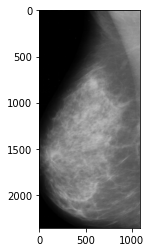

In [ ]:
# Load image, convert to grayscale, and find edges
image = cv2.imread('/content/drive/MyDrive/DDSM/Imagens crop/2341.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

# Find contour and sort by contour area
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# Find bounding box and extract ROI
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    ROI = image[y:y+h, x:x+w]
    break

cv2.imwrite('ROI.png',ROI)
#Show the image with matplotlib
plt.imshow(ROI)
plt.show()


In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9 MB 4.2 MB/s 


In [ ]:
%pylab inline
import cv2
import numpy as np
import pydicom as dicom
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [ ]:

def gen_maxval_mask(dtype):
    '''Generate a maxval binary mask for a numpy uintX dtype
    '''
    if dtype not in [np.uint8, np.uint16, np.uint32, np.uint64]:
        raise Exception
    return np.array([-1]).astype(dtype)[0]

In [ ]:
mammo_org = cv2.imread('/content/drive/MyDrive/DDSM/Imagens crop/2341.png', 
                       cv2.IMREAD_GRAYSCALE)

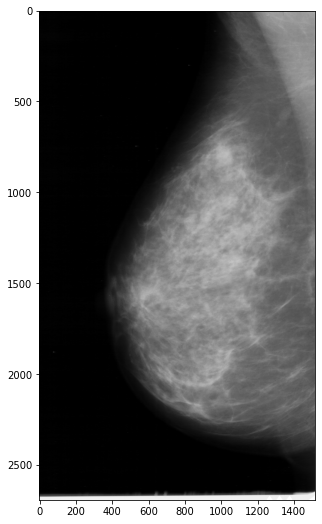

In [ ]:
fig,ax = subplots()
fig.set_size_inches([6, 9])
ax.imshow(mammo_org, cmap='gray')

In [ ]:
def scale_image_01(img):
    return (img.astype(np.float64) - img.min()) / (img.max() - img.min())

mammo_scaled = scale_image_01(mammo_org)

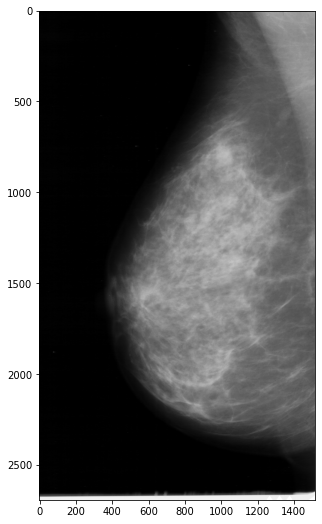

In [ ]:
fig,ax = subplots()
fig.set_size_inches([6, 9])
ax.imshow(mammo_scaled, cmap='gray')

In [ ]:

from scipy.sparse import coo_matrix, hstack

In [ ]:

def convert_scale_alpha(maxval):
    return 255.0/maxval

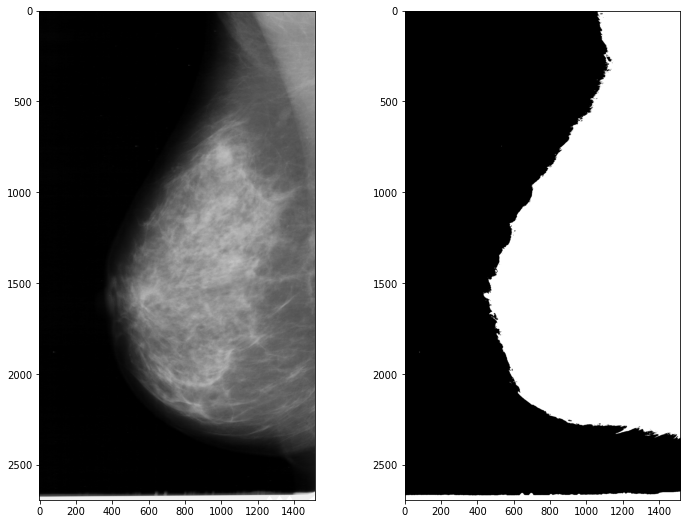

In [ ]:
global_threshold = 18  # from Nagi thesis. <<= para to tune!
#mammo_med_blurred_col = cv2.cvtColor(mammo_med_blurred, cv2.COLOR_GRAY2BGR)
#mammo_med_blurred_u8 = cv2.convertScaleAbs(mammo_med_blurred, alpha=u16u8_alpha)
#_, mammo_binary = cv2.threshold(mammo_med_blurred, 187, 
#                                maxval=255, type=cv2.THRESH_OTSU)
_,mammo_binary = cv2.threshold(mammo_org,0,maxval = 255,type =cv2.THRESH_BINARY + cv2.THRESH_OTSU)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_binary, cmap='gray')

In [ ]:
def select_largest_obj(img_bin, lab_val=255, fill_holes=False, 
                       smooth_boundary=False, kernel_size=15):
    '''Selecione o maior objeto de uma imagem binária e opcionalmente
        preenche os buracos dentro dele e suaviza seu limite.
        Args:
            img_bin (2D array): 2D numpy array da imagem binária.
            lab_val ([int]): integer value -> label (largest 
                    object). Default = 255.
            fill_holes ([boolean]): se preenche os buracos dentro do maior 
                    objeto ou não. Default = false.
            smooth_boundary ([boolean]): se suaviza o limite do 
                    maior objeto usando abertura morfológica ou não.
                    Default = false.
            kernel_size ([int]): o tamanho do kernel usado para operação morfológica.
             Default = 15.
        Returns:
        	Binary mask (:
    
    from: 

    '''
    n_labels, img_labeled, lab_stats, _ = cv2.connectedComponentsWithStats(
        img_bin, connectivity=8, ltype=cv2.CV_32S)
    largest_obj_lab = np.argmax(lab_stats[1:, 4]) + 1
    largest_mask = np.zeros(img_bin.shape, dtype=np.uint8)
    largest_mask[img_labeled == largest_obj_lab] = lab_val
    if fill_holes:
        bkg_locs = where(img_labeled == 0)
        bkg_seed = (bkg_locs[0][0], bkg_locs[1][0])
        img_floodfill = largest_mask.copy()
        h_, w_ = largest_mask.shape
        mask_ = np.zeros((h_ + 2, w_ + 2), dtype=np.uint8)
        cv2.floodFill(img_floodfill, mask_, seedPoint=bkg_seed, newVal=lab_val)
        holes_mask = cv2.bitwise_not(img_floodfill)  # mask of the holes.
        largest_mask = largest_mask + holes_mask
    if smooth_boundary:
        kernel_ = np.ones((kernel_size, kernel_size), dtype=np.uint8)
        largest_mask = cv2.morphologyEx(largest_mask, cv2.MORPH_OPEN, kernel_)
        
    return largest_mask

In [ ]:
#u16_maxval = gen_maxval_mask(mammo_med_blurred.dtype)
mammo_breast_mask = select_largest_obj(mammo_binary, lab_val=255, 
                                       fill_holes=False, 
                                       smooth_boundary=False, kernel_size=15)  # <<= para to tune!

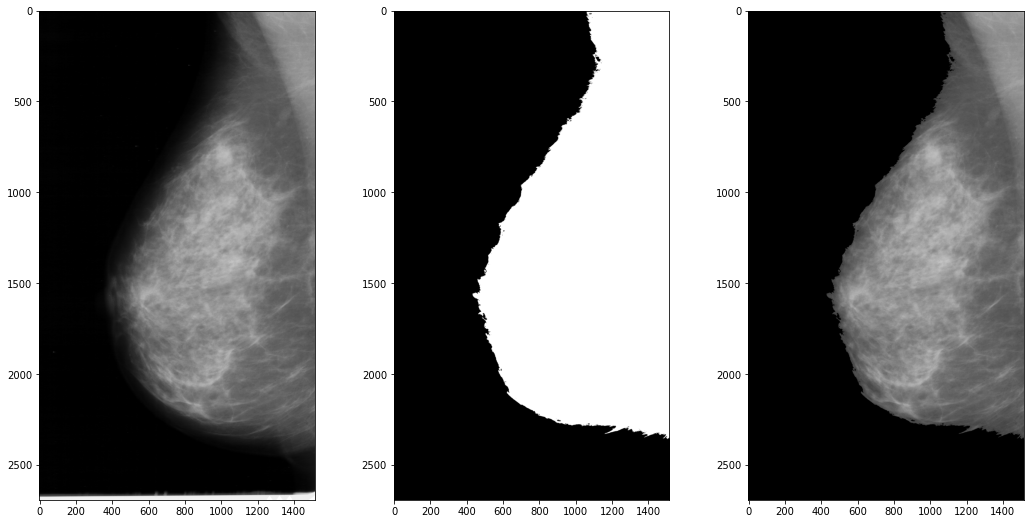

In [ ]:
mammo_arti_suppr = cv2.bitwise_and(mammo_org, mammo_breast_mask)
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_org, cmap='gray')
axes[1].imshow(mammo_breast_mask, cmap='gray')
axes[2].imshow(mammo_arti_suppr, cmap='gray')

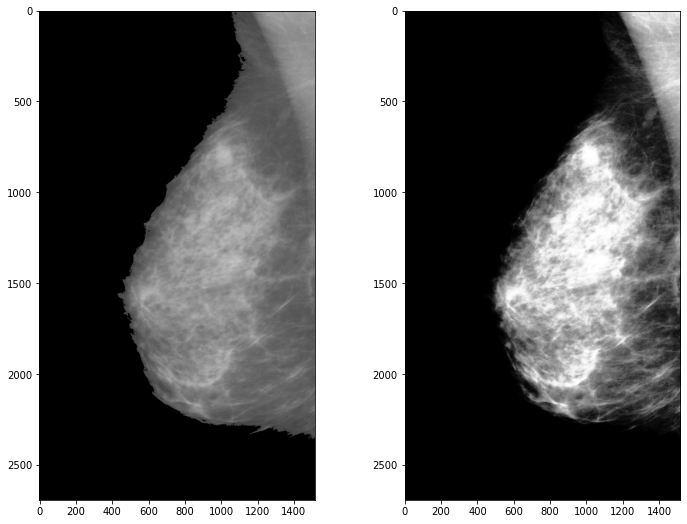

In [ ]:
mammo_breast_equ = cv2.equalizeHist(mammo_arti_suppr)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_arti_suppr, cmap='gray')
axes[1].imshow(mammo_breast_equ, cmap='gray')

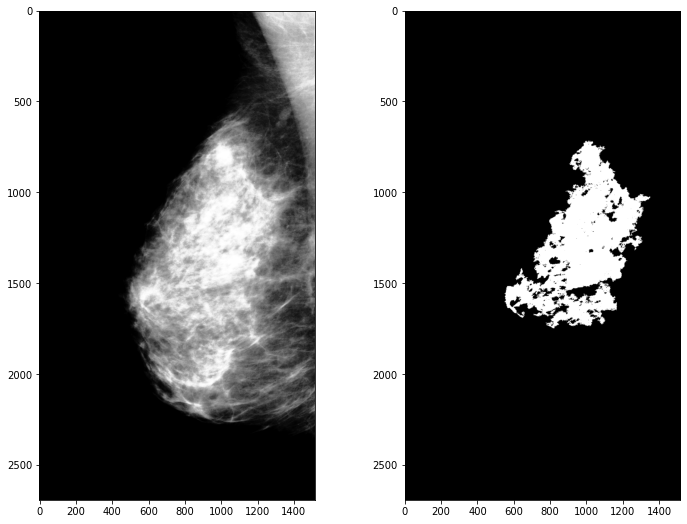

In [ ]:
pect_high_inten_thres = 190# <<= para to tune!
_, pect_binary_thres = cv2.threshold(mammo_breast_equ, pect_high_inten_thres, 
                                     maxval=255, type=cv2.THRESH_BINARY)
largest_mask = select_largest_obj(pect_binary_thres,255,False,False,15)
#l_mask = select_largest_obj(largest_mask, 255, False, False, 15)

fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
#res = hstack((mammo_med_blurred, mammo_binary))
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(largest_mask, cmap='gray')

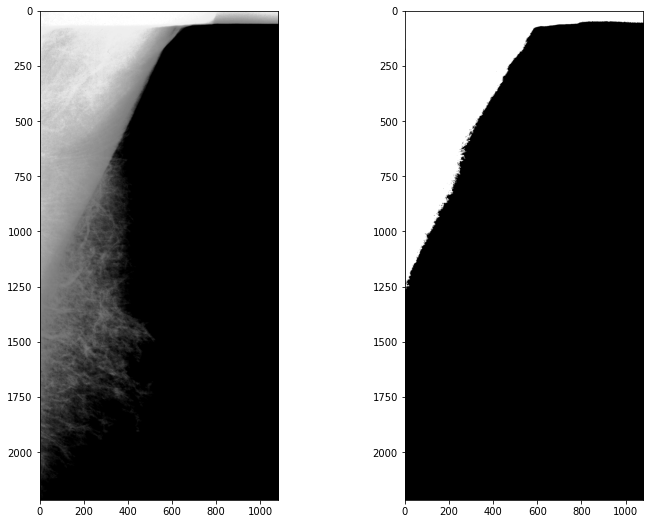

In [ ]:
largest_mask = select_largest_obj(largest_mask,255,False,False,15)
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(largest_mask, cmap='gray')

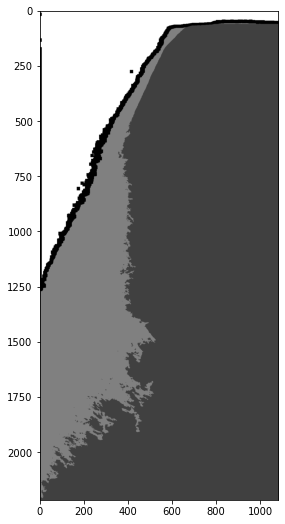

In [ ]:
# Markers image for watershed algo.
pect_marker_img = np.zeros(largest_mask.shape, dtype=np.int32)
# Sure foreground.
pect_mask_init = select_largest_obj(largest_mask, lab_val=255, 
                                    fill_holes=False, smooth_boundary=False)
kernel_ = np.ones((3, 3), dtype=np.uint8)  # <<= para to tune!
n_erosions = 7  # <<= para to tune!
pect_mask_eroded = cv2.erode(pect_mask_init, kernel_, iterations=n_erosions)
pect_marker_img[pect_mask_eroded > 0] = 255
# Sure background - breast.
n_dilations = 7  # <<= para to tune!
pect_mask_dilated = cv2.dilate(pect_mask_init, kernel_, iterations=n_dilations)
pect_marker_img[pect_mask_dilated == 0] = 128
# Sure background - background.
pect_marker_img[mammo_breast_mask == 0] = 64
# plot.
fig,ax = subplots()
fig.set_size_inches([6, 9])
ax.imshow(pect_marker_img, cmap='gray')

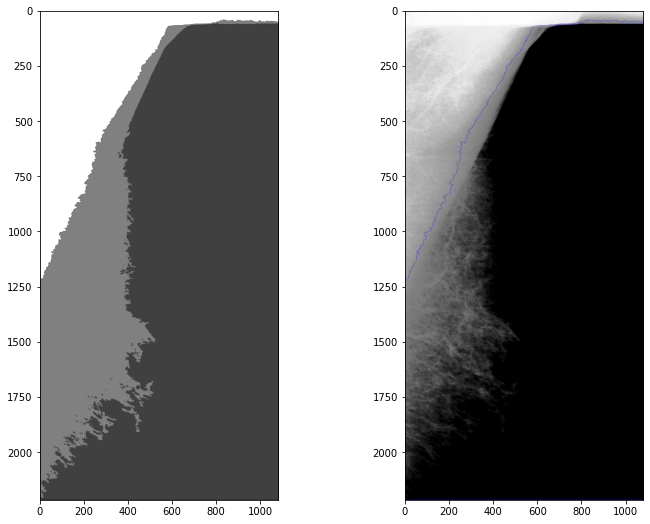

In [ ]:
mammo_breast_equ_3c = cv2.cvtColor(mammo_breast_equ, cv2.COLOR_GRAY2BGR)
cv2.watershed(mammo_breast_equ_3c, pect_marker_img)
pect_mask_watershed = pect_marker_img.copy()
mammo_breast_equ_3c[pect_mask_watershed == -1] = (0, 0, 255)
pect_mask_watershed[pect_mask_watershed == -1] = 0
fig,axes = subplots(1, 2)
fig.set_size_inches([12, 9])
axes[0].imshow(pect_mask_watershed, cmap='gray')
axes[1].imshow(mammo_breast_equ_3c)

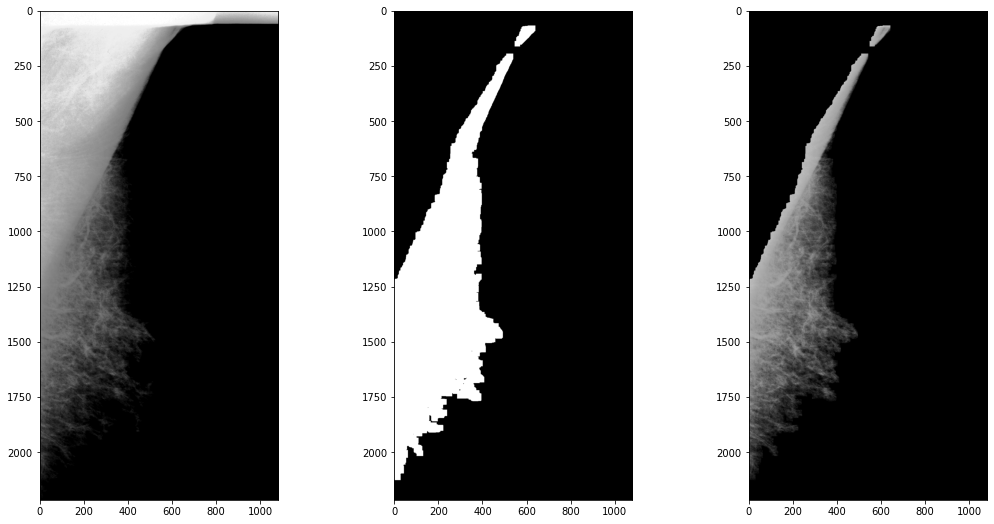

In [ ]:
breast_only_mask = pect_mask_watershed.astype(np.uint8)
breast_only_mask[breast_only_mask != 128] = 0
breast_only_mask[breast_only_mask == 128] = 255
kn_size = 25  # <<= para to tune!
kernel_ = np.ones((kn_size, kn_size), dtype=np.uint8)
breast_only_mask_smo = cv2.morphologyEx(breast_only_mask, cv2.MORPH_OPEN, kernel_)
mammo_breast_only = cv2.bitwise_and(mammo_breast_equ, breast_only_mask_smo)
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(mammo_breast_equ, cmap='gray')
axes[1].imshow(breast_only_mask_smo, cmap='gray')
axes[2].imshow(mammo_breast_only, cmap='gray')

In [ ]:

cv2.imwrite('/content/drive/MyDrive/DDSM/Imagens crop/7-1.png',mammo_breast_only)

True

Fix features


In [ ]:
import cv2
import numpy as np

# read image
img = cv2.imread('/content/drive/MyDrive/DDSM/Imagens crop/7.png')

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold and invert
thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]
thresh1 = 255 - thresh1

# remove borders
# count number of white pixels in columns as new 1D array
count_cols = np.count_nonzero(thresh1, axis=0)

# get first and last x coordinate where black
first_x = np.where(count_cols>0)[0][0]
last_x = np.where(count_cols>0)[0][-1]
print(first_x,last_x)

# count number of white pixels in rows as new 1D array
count_rows = np.count_nonzero(thresh1, axis=1)

# get first and last y coordinate where black
first_y = np.where(count_rows>0)[0][0]
last_y = np.where(count_rows>0)[0][-1]
print(first_y,last_y)

# crop image
crop = img[first_y:last_y+1, first_x:last_x+1]

# crop thresh1 and invert
thresh2 = thresh1[first_y:last_y+1, first_x:last_x+1]
thresh2 = 255 - thresh2

# get external contours and keep largest one
contours = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)

# make mask from contour
mask = np.zeros_like(thresh2 , dtype=np.uint8)
cv2.drawContours(mask, [big_contour], 0, 255, -1)

# make crop black everywhere except where largest contour is white in mask
result = crop.copy()
result[mask==0] = (0,0,0)

# write result to disk
cv2.imwrite("xray2_thresh1.png", thresh1)
cv2.imwrite("xray2_crop.png", crop)
cv2.imwrite("xray2_thresh2.png", thresh2)
cv2.imwrite("xray2_mask.png", mask)
cv2.imwrite("xray2_result.png", result)

# display it
fig,axes = subplots(1, 3)
fig.set_size_inches([18, 9])
axes[0].imshow(thresh1, cmap='gray')
axes[1].imshow(crop, cmap='gray')
axes[2].imshow(result, cmap='gray')


In [ ]:
def compare_files():
        path = glob.glob('/content/drive/MyDrive/DDSM/Imagens/Left/*.png')
        #PATH2 = ('C:\\Users\\Ariadne\\Desktop\\datasets\\bin masks')
        for i in path:
            gray_ = cv2.imread(i,0)
            bin_ = i.replace("Left","Mascaras")
            mask_ = cv2.imread(bin_,0)
            op_and = cv2.bitwise_and(gray_,mask_)
            cv2.imwrite(i,op_and)
                       

In [ ]:
compare_files()

In [ ]:
def boudingbox_roi_image(path):

        for i, im in enumerate(path):
            image = cv2.imread(im,0)
            contours,hierarchy = cv2.findContours(image, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
            count = 0
            for cnt in contours:
                count +=1
                x,y,w,h = cv2.boundingRect(cnt)
                roi = image[y:y+h,x:x+w]
                cv2.imwrite(im, roi)

In [ ]:

path = glob.glob('/content/drive/MyDrive/DDSM/Imagens/Left/*.png')

In [ ]:
boudingbox_roi_image(path)

In [ ]:
def resize_images_out():

        path = glob.glob('/content/drive/MyDrive/DDSM/Imagens/MLO/*.png')

        for x in path: 
            print(x)
            gray_ = cv2.imread(x)
            mask = x.replace("Mammo","MLO")
            bin_ = cv2.imread(mask)
            print(bin_)
            print(bin_)
            op_and = cv2.bitwise_and(gray_,bin_)
            width = gray_.shape[1]
            height = gray_.shape[0]
            print(width,height)
            dim = (width,height)
            resize = cv2.resize(bin_,dim,interpolation = cv2.INTER_AREA)
            cv2.imwrite(x,resize)


In [ ]:
resize_images_out()

/content/drive/MyDrive/DDSM/Imagens/MLO/p0.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p1.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p2.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p3.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p4.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p5.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p6.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p7.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p8.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p9.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p10.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p11.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p12.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p13.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p14.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p15.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p16.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p17.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p18.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p19.png
/content/drive/MyDrive/DDSM/Imagens/MLO/p20.png
/c

In [ ]:
from os import rename

In [ ]:
 def rename_files_img(path):
    	for i,filename in enumerate(os.listdir(path)):
            #if filename.endswith("RIGHT_MLO.png"):
                #os.rename(os.path.join(path,filename),os.path.join(path,filename.replace('2.png', '.png')))
                os.rename(r'/content/drive/MyDrive/DDSM/Imagens/MLO/'+filename,r'/content/drive/MyDrive/DDSM/Imagens/MLO/'+str('p')+str(i)+'.png')
                #print(path+'\\'+filename)

In [ ]:
path = ('/content/drive/MyDrive/DDSM/Imagens/MLO')

In [ ]:
rename_files_img(path)